# Held Out Participant Compared to Group-wise templates- Jaccard Analysis of Segmentation Data
### Started September 30, 2020

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.plotly as py
import plotly
import os
import glob
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import copy
from random import randrange
import random
from sklearn.metrics import jaccard_score
%autosave 5

Autosaving every 5 seconds


### i. Import data
#### A. Participant Data

In [2]:
filename = '/Users/alexreblando/Documents/Documents - Alex’s MacBook Air/GitHub/data_analysis_ebs/online_experiment/analysis/segment/usable_data'
data_dict = pickle.load( open( filename, "rb" ) )
filename_sums = '/Users/alexreblando/Documents/Documents - Alex’s MacBook Air/GitHub/data_analysis_ebs/online_experiment/analysis/segment/sums_usable_data'
sums = pickle.load( open( filename_sums, "rb" ) )
len(data_dict)

311

# I. Separating the Priming Groups For Each Story
## A. group stories by subject and priming type
#### - output: loc_keys_r

In [3]:
loc_keys_r = dict()
soc_keys_r = dict()
none_keys_r = dict()
all_keys_r = dict()

for key in data_dict:
    this_story = data_dict[key]['story'].iloc[0]
    keys = data_dict[key]['story_presses']
    p_type = data_dict[key]['p_type'].iloc[0]
    #print out the filenames and prolific ids of people who did not press "9" once
    occurrences = np.count_nonzero(keys == 9)
    if occurrences == 0:
        print(key)
        print(data_dict[key]['prolific_id'].iloc[0])
    #put all story keys in the same dictionary regardless of priming
    if this_story in all_keys_r:
        all_keys_r[this_story] = np.concatenate((all_keys_r[this_story],keys[:,np.newaxis]), axis=1)
    else:
        all_keys_r[this_story] = keys[:, np.newaxis]
    #organize keys by priming type
    #no prime
    if p_type == 0:
        if this_story in none_keys_r:
            none_keys_r[this_story] = np.concatenate((none_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            none_keys_r[this_story] = keys[:, np.newaxis]
    #loc prime
    elif p_type == 1:
        if this_story in loc_keys_r:
            loc_keys_r[this_story] = np.concatenate((loc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            loc_keys_r[this_story] = keys[:, np.newaxis]
    #soc prime
    elif p_type == 2:
        if this_story in soc_keys_r:
            soc_keys_r[this_story] = np.concatenate((soc_keys_r[this_story],keys[:,np.newaxis]), axis=1)
        else:
            soc_keys_r[this_story] = keys[:, np.newaxis]

<ipython-input-3-2bd4433a67cf>:19: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-3-2bd4433a67cf>:26: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-3-2bd4433a67cf>:19: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-3-2bd4433a67cf>:26: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

<ipython-input-3-2bd4433a67cf>:19: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecate

## B. Convert keypresses from '9's and '1's to '1's and '0's
#### - output loc_keys
#### - WARNING: you can only run this once!!!!!! if you run twice, you must start from the beginning

In [4]:
loc_keys = dict()
soc_keys = dict()
none_keys = dict()
all_keys = dict()

#all keys
for key in all_keys_r:
    this_array = copy.deepcopy(all_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    all_keys[key] = this_array   
    
#none keys
for key in none_keys_r:
    this_array = copy.deepcopy(none_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    none_keys[key] = this_array   
    
#loc keys
for key in loc_keys_r:
    this_array = copy.deepcopy(loc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    loc_keys[key] = this_array   
    
#soc keys
for key in soc_keys_r:
    this_array = copy.deepcopy(soc_keys_r[key])
    this_array[this_array ==1] = 0
    this_array[this_array == 9] = 1
    soc_keys[key] = this_array   

## C. Remove first sentence (first row) from all keypresses

In [5]:
list_keys = [all_keys, none_keys, loc_keys, soc_keys]
for i in range(0, len(list_keys)):
    for key in list_keys[i]:
        list_keys[i][key] = np.delete(list_keys[i][key],(0), axis = 0)

# III. Held-out participants template analysis
## A. Create a 3x3 matrix

In [6]:
template_ji_m = {}


for key in all_keys:
    # Primed_template_jis
    NP_NP_jis = []
    NP_L_jis = []
    NP_S_jis = []
    L_NP_jis = []
    L_L_jis = []
    L_S_jis = []
    S_NP_jis = []
    S_L_jis = []
    S_S_jis = []
    
    # Organize these lists into a 3x3 array
    ji_lists = [[NP_NP_jis, L_NP_jis, S_NP_jis], [NP_L_jis, L_L_jis, S_L_jis], [NP_S_jis, L_S_jis, S_S_jis]]
    
    for i in range(0, sums[key][0]):
        ## Get hold out participants, updated group keys
        
        # Get a new sums tab
        temp_sums = copy.deepcopy(sums[key])
        # If the excluded participant is NP
        if i < sums[key][1]:
            # Record held out participant
            held_out = none_keys[key][:, i]
            # exclude the participant from None_keys
            this_none = np.delete(none_keys[key], i, 1)
            # Assign other groups of participants
            this_loc = copy.deepcopy(loc_keys[key])
            this_soc = copy.deepcopy(soc_keys[key])
            # Change the Sums count
            temp_sums[1] = sums[key][1] - 1
            # mark the column in the 3x3
            this_col = 0
        # if the excluded participant is S
        elif i < sums[key][1] + sums[key][2]:
            # Get the participant #
            this_partc = i - sums[key][1]
            # Record held out participant
            held_out = loc_keys[key][:, this_partc]
            # exclude the participant from loc_keys
            this_loc = np.delete(loc_keys[key], this_partc, 1)
            # Assign other groups of participants
            this_none = copy.deepcopy(none_keys[key])
            this_soc = copy.deepcopy(soc_keys[key])
            # Change the Sums count
            temp_sums[2] = sums[key][2] - 1
            # mark the column in the 3x3
            this_col = 1
        # If the excluded participant is L
        else:
            # Get the participant #
            this_partc = i - (sums[key][1] + sums[key][2])
            # Record held out participant
            held_out = soc_keys[key][:, this_partc]
            # exclude the participant from loc_keys
            this_soc = np.delete(soc_keys[key], this_partc, 1)
            # Assign other groups of participants
            this_loc = copy.deepcopy(loc_keys[key])
            this_none = copy.deepcopy(none_keys[key])
            # Change the Sums count
            temp_sums[3] = sums[key][3] - 1
            # mark the column in the 3x3
            this_col = 2
            
        ## Find the median number of boundaries across all participants
        # Sum down the columns
        none_sum = np.sum(this_none, axis = 0)
        loc_sum = np.sum(this_loc, axis = 0)
        soc_sum = np.sum(this_soc, axis = 0)
        # Concatenate the three groups
        all_sums = np.concatenate((none_sum, loc_sum, soc_sum))
        # Calculate median
        this_median = np.median(all_sums)
        
        ## Sum keypresses row-wise
        none_sum_k = np.sum(this_none, axis = 1)
        loc_sum_k = np.sum(this_loc, axis = 1)
        soc_sum_k = np.sum(this_soc, axis = 1)
        
        ## Construct the template based on top sums of participant keypresses
        
        # Instantiate temps
        none_temp = np.zeros((none_sum_k.shape))
        loc_temp = np.zeros((none_sum_k.shape))
        soc_temp = np.zeros((none_sum_k.shape))
        
        # Make lists for iterating through different groups
        list_sums = [none_sum_k, loc_sum_k, soc_sum_k]
        list_temps = [none_temp, loc_temp, soc_temp]
        
        for k in range(0, len(list_sums)):
            count = 0
            while count <= this_median:
                result = np.where(list_sums[k] == np.amax(list_sums[k]))
                # If result is greater than 1 shuffle the order
                if result[0].shape[0] > 1:
                    new_res = np.array(random.sample(list(result[0]), len(list(result[0]))))
                else:
                    new_res = result[0]
                # Iterate through new_res and update the template and sums arrays
                for i in range(0,new_res.shape[0]):
                    count += 1
                    if count <= this_median:
                        # Add index to template
                        list_temps[k][result[0][i]] = 1
                        # Remove sum from sum array
                        list_sums[k][result[0][i]] = 0
                        
        ## Compare the held out subject to each template
        ji_none = jaccard_score(held_out, none_temp)
        ji_loc = jaccard_score(held_out, loc_temp)
        ji_soc = jaccard_score(held_out, soc_temp)
        
        ## Append jis into lists
        jis = [ji_none, ji_loc, ji_soc]
        
        for m in range(0, 3):
            ji_lists[m][this_col].append(jis[m])
            
    ## Average across all the held out subjects to get one 3 x 3 matrix
    # Instantiate 3x3
    this_matrix = np.zeros((3,3))
    
    for i in range(0, 3):
        for j in range(0, 3):
            this_matrix[i,j] = np.mean(np.asarray(ji_lists[i][j]))
            
    template_ji_m[key] = this_matrix 

## B. Plot each individual story

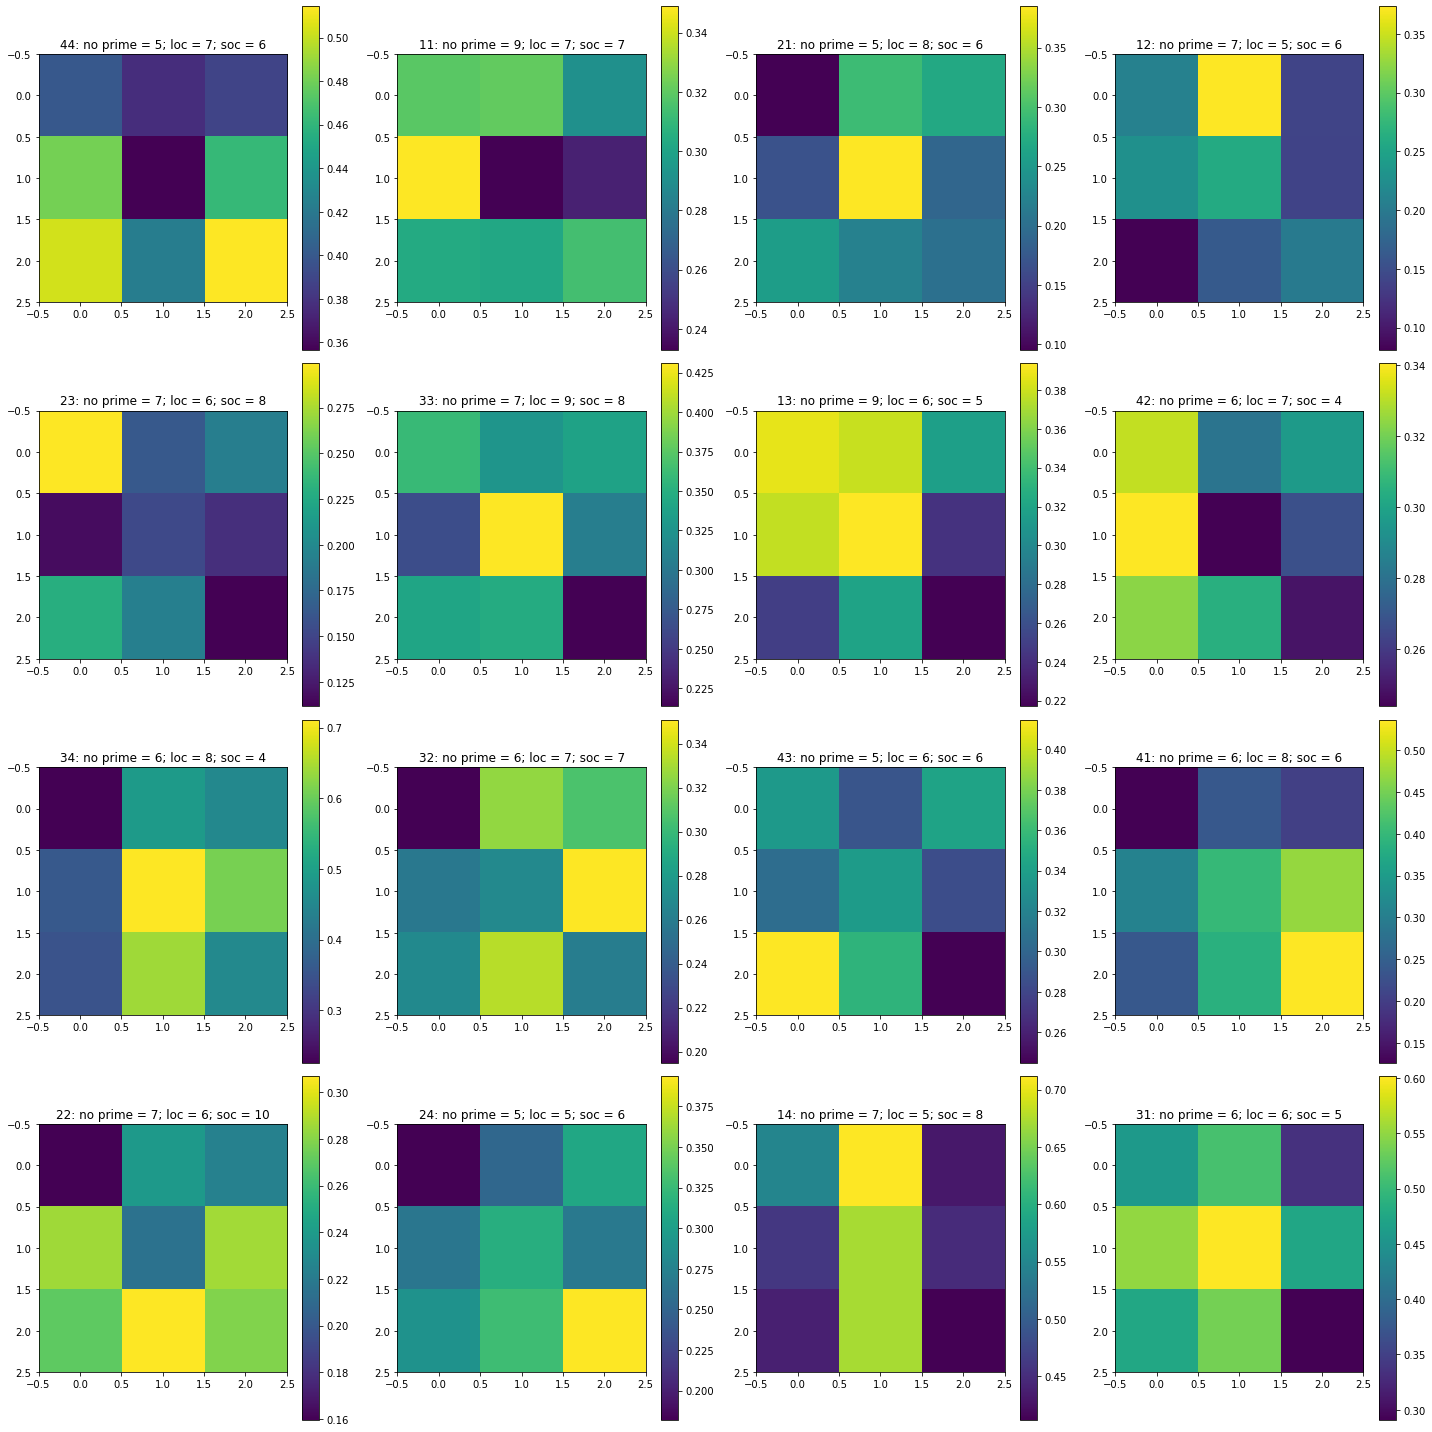

In [7]:
figure, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))

i = 0
j = 0
for key in template_ji_m:
    # Make the plot
    im = axes[j, i].imshow(template_ji_m[key])
    
    #colorbar
    im.set_clim()
    figure.colorbar(im, ax=axes[j, i])
    
    #set title
    none_n = sums[key][1]
    loc_n = sums[key][2]
    soc_n = sums[key][3]
    axes[j, i].set_title(str(key) + ': no prime = ' + str(none_n) + '; loc = ' + str(loc_n) + '; soc = ' + str(soc_n))
    
    #changing i, j for next graph placement
    if i == 3:
        i = 0
        j += 1
    else:
        i += 1
    figure.tight_layout()

## C. Average across all stories

In [8]:
# Concatenate Matrices along the third dimension
count = 0
for key in template_ji_m:
    if count == 0:
        all_stories = template_ji_m[key]
        count =+ 1
    else:
        all_stories = np.dstack((all_stories, template_ji_m[key]))

# NanMean
avg_all_stories_actual = np.nanmean(all_stories, axis = 2)

## D. Plot the average across all stories

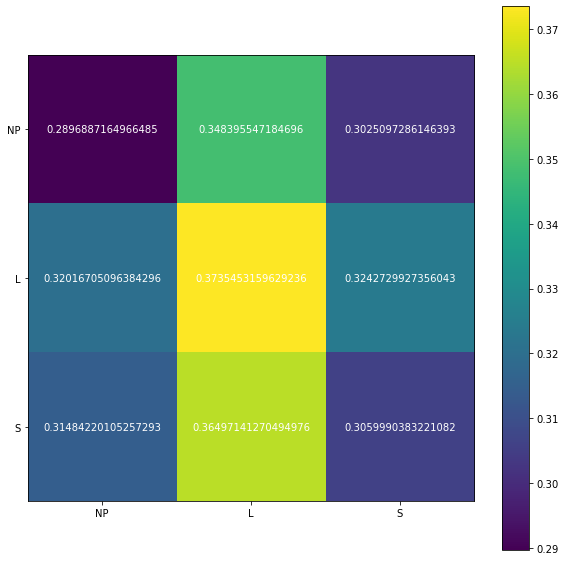

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
im = ax.imshow(avg_all_stories_actual)

fig.colorbar(im)

# X ticks
x_label_list = ['NP', 'L', 'S']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)

# Y ticks
y_label_list = ['NP', 'L', 'S']
ax.set_yticks([0,1,2])
ax.set_yticklabels(x_label_list)

# Adding values to boxes
# Loop over data dimensions and create text annotations.
for i in range(0, 3):
    for j in range(0, 3):
        text = ax.text(i, j, avg_all_stories_actual[j, i], ha="center", va="center", color="w")